## Time Series Forecasting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

%matplotlib inline

In [2]:
df = pd.read_pickle('data/train.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18288 entries, 2012-08-25 00:00:00 to 2014-09-25 23:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Count   18288 non-null  int64
 1   year    18288 non-null  int64
 2   month   18288 non-null  int64
 3   day     18288 non-null  int64
 4   Hour    18288 non-null  int64
dtypes: int64(5)
memory usage: 857.2 KB


In [3]:
df.index.min()

Timestamp('2012-08-25 00:00:00')

In [4]:
df.index.max()

Timestamp('2014-09-25 23:00:00')

### Train/Test Split 

In [5]:
train=df.loc['2012-08-25':'2014-06-24'] 
valid=df.loc['2014-06-25':'2014-09-25']

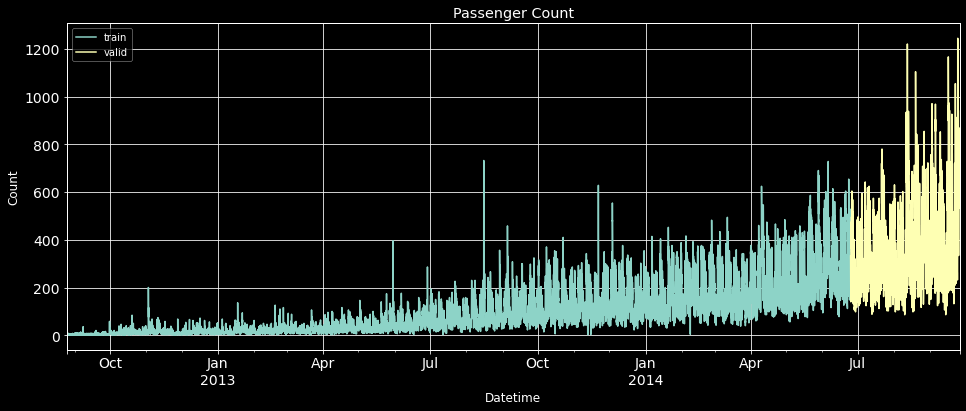

In [6]:
plt.style.use('dark_background')
train.Count.plot(figsize=(16,6), title= 'Passenger Count', fontsize=14, 
                 label='train', xlabel = "Datetime", ylabel = "Count") 
valid.Count.plot(figsize=(16,6), label='valid')  
plt.legend(loc='best')
plt.show()

In [7]:
# Daily data 
traind = train[['Count']].resample('D').sum()
validd = valid[['Count']].resample('D').sum()

### Exponential Smoothing

* **Simple Exponential Smoothing:** We assign larger weights to more recent observations, The weights decrease exponentially as observations come from further in the past.
* **Holt’s Linear Trend Model:** Extension of simple exponential smoothing to allow us forecasting data with a trend. It takes into account the trend of the dataset.
* **Holt Winter's Model:** Extension of simple exponential smoothing, that takes into account both trend and seasonality to forecast.

In [8]:
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt 

In [9]:
# Simple Exponential Smoothing
swe = SimpleExpSmoothing(traind.Count).fit(smoothing_level=0.3) 
pred_swe = swe.forecast(len(validd))
pred_swe = pd.DataFrame(index=pred_swe.index, data = pred_swe.values, columns=['Count'])

In [10]:
def plot_forecast(train, test, predictions_df):
    train.Count.plot(title='Airline passengers predictions', label='Training data', figsize = (16,6))
    test.Count.plot(color='gray', label='Testing data')
    predictions_df.Count.plot(color='red', label='Predictions')
    plt.legend();

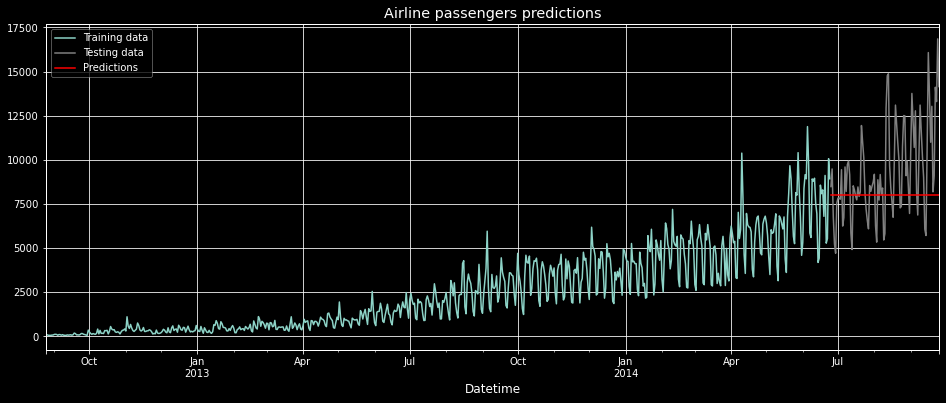

In [11]:
plot_forecast(traind, validd, pred_swe)

In [12]:
holt = Holt(traind.Count).fit(smoothing_level = 0.3,smoothing_slope = 0.1) 
pred_holt = holt.forecast(len(validd))
pred_holt = pd.DataFrame(index=pred_holt.index, data = pred_holt.values, columns=['Count'])

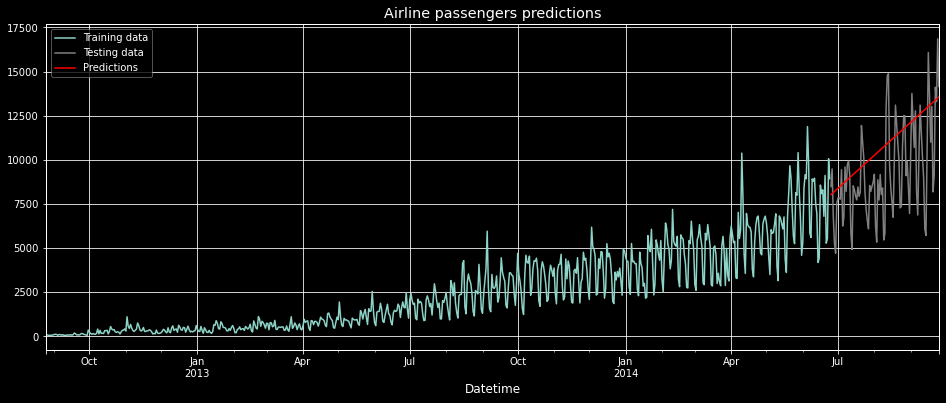

In [13]:
plot_forecast(traind, validd, pred_holt)

In [14]:
ESA = ExponentialSmoothing(traind.Count,seasonal_periods=7 ,trend='add', seasonal='add').fit() 
pred_ESA = ESA.forecast(len(validd))
pred_ESA = pd.DataFrame(index=pred_ESA.index, data = pred_ESA.values, columns=['Count'])

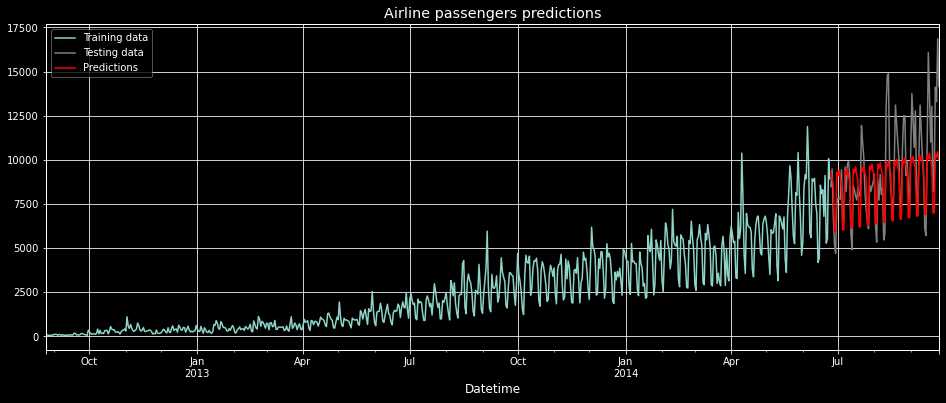

In [15]:
plot_forecast(traind, validd, pred_ESA)

In [16]:
ESM = ExponentialSmoothing(traind.Count,seasonal_periods=7 ,trend='mul', seasonal='mul').fit() 
pred_ESM = ESM.forecast(len(validd))
pred_ESM = pd.DataFrame(index=pred_ESM.index, data = pred_ESM.values, columns=['Count'])

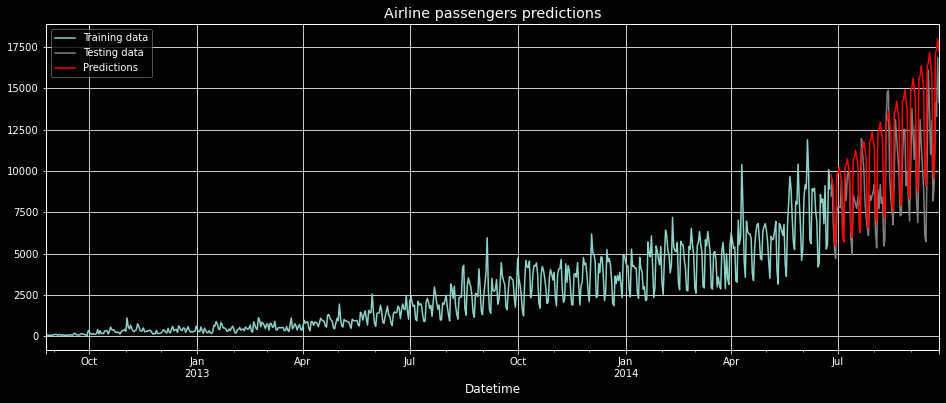

In [17]:
plot_forecast(traind, validd, pred_ESM)

### Autoregressive Integrated Moving Averages

ARIMA models workflow:
* Visualize the Time Series Data
* Check stationarity
* Visualize the Correlation and AutoCorrelation plots
* Construct the ARIMA Model
* Make predictions

In [18]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [19]:
# houtly data
def ADF(serie):
    result = adfuller(serie)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
ADF(train.Count)

ADF Statistic: -5.046773
p-value: 0.000018
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### Autocorrelation and Partial Autocorrelation Plots

**Autocorrelation plot:**  Represent the correlation of the series with itself, lagged by x time units. So the y axis is the correlation and the x axis is the number of time units of lag. It used to determine the MA order.


**Partial Autocorrelation plot:**  Represent the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed. It used to determine the AR order.

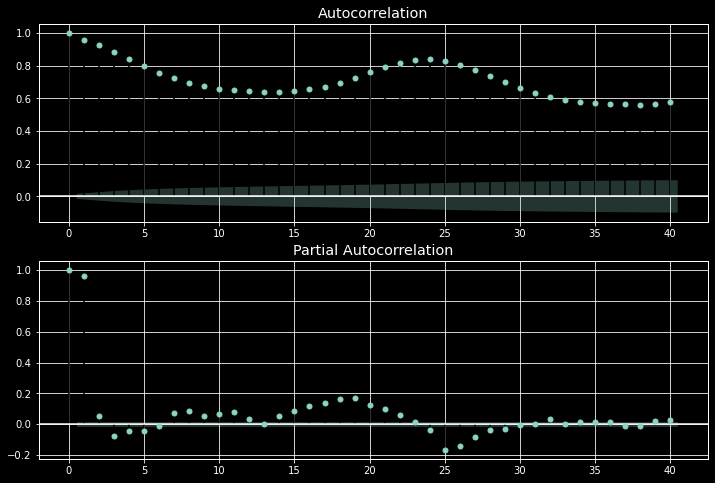

In [20]:
fig = plt.style.use('dark_background')
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(train.Count, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train.Count, lags=40, ax=ax2)

In [21]:
def arima_forecast(series, order, freq, test):
    model = ARIMA(series, order = order, freq = freq)
    result = model.fit()
    predictions = result.forecast(steps=len(test))
    predictions_df = pd.DataFrame(index=test.index, data=predictions[0], columns=["Count"])
    return result, predictions_df

#### Moving Average Model (MA)

Assumes the value of the dependent variable on the current day depends on the previous days error terms. The formula can be expressed as:
\begin{equation}
y_t = \epsilon_t + \alpha_1 \epsilon_{t-1} + \alpha_2 \epsilon_{t-2} + ... + \alpha_q \epsilon_{t-q}
\end{equation}

In [22]:
ma_model, ma_pred = arima_forecast(train.Count, (0, 0, 1), 'H', valid)

In [23]:
#ma_model.summary()

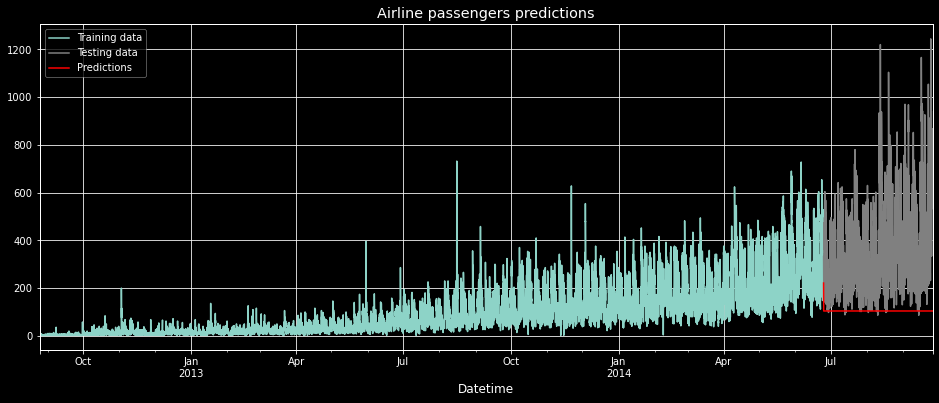

In [24]:
plot_forecast(train, valid, ma_pred)

#### AutoRegressive Model (AR)

Autoregressive models operate under the premise that past values have an effect on current values. AR models are commonly used in analyzing nature, economics, and other time-varying processes. As long as the assumption holds, we can build a linear regression model that attempts to predict value of a dependent variable today, given the values it had on previous days.

\begin{equation}
y_t = \beta_1 y_{t-1} + \beta_2 y_{t-2} + ... + \beta_p y_{t-p}
\end{equation}

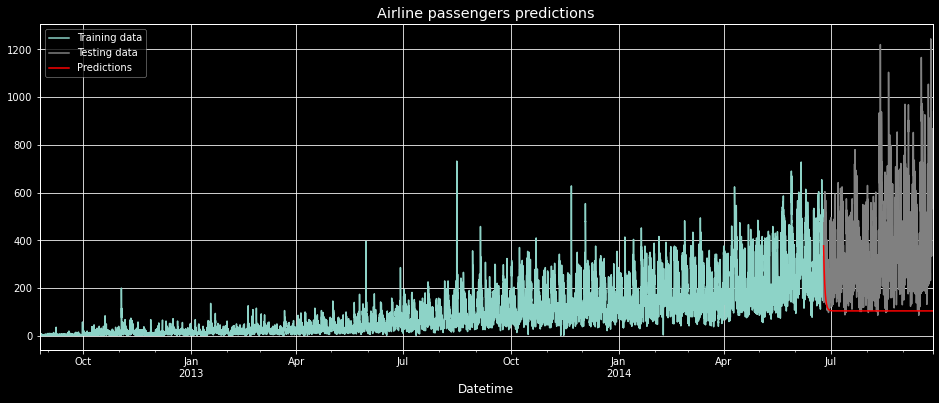

In [25]:
ar_model, ar_pred = arima_forecast(train.Count, (2, 0, 0), 'H', valid)
plt.style.use('dark_background')
plot_forecast(train, valid, ar_pred)

#### Auto Regressive Moving Average (ARMA)

The ARMA model is simply the combination of the AR and MA models.
\begin{equation}
y_t = \beta_1 y_{t-1} + \beta_2 y_{t-2} + ... + \beta_p y_{t-p} + \epsilon_t + \alpha_1 \epsilon_{t-1} + \alpha_2 \epsilon_{t-2} + ... + \alpha_q \epsilon_{t-q}
\end{equation}

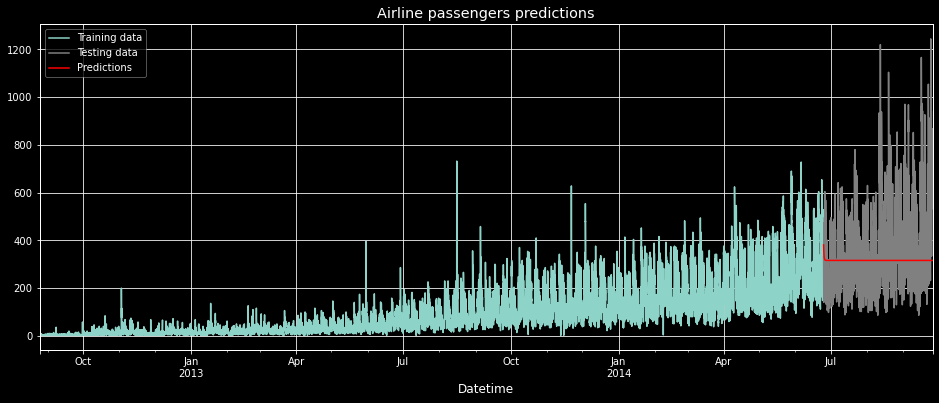

In [26]:
arma_model, arma_pred = arima_forecast(train.Count, (2, 0, 2), 'H', valid)
plt.style.use('dark_background')
plot_forecast(train, valid, arma_pred)

#### Daily airline passengers predictions

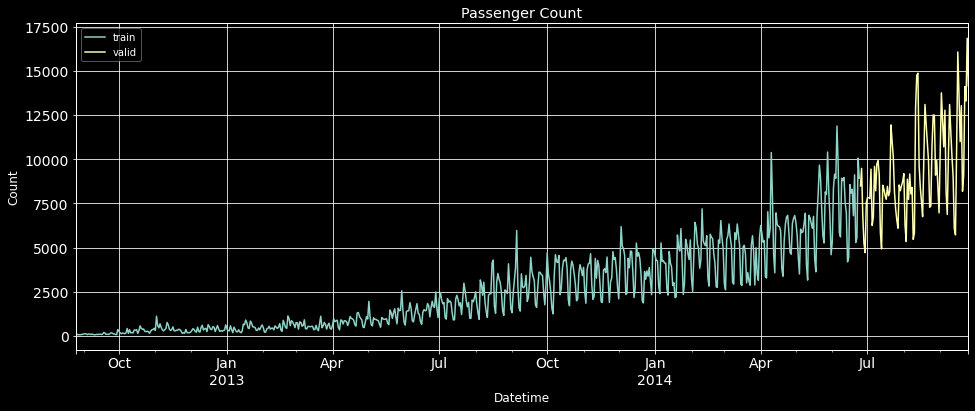

In [27]:
plt.style.use('dark_background')
traind.Count.plot(figsize=(16,6), title= 'Passenger Count', fontsize=14, 
                 label='train', xlabel = "Datetime", ylabel = "Count") 
validd.Count.plot(figsize=(16,6), label='valid')  
plt.legend(loc='best')
plt.show()

In [28]:
def ADF(serie):
    result = adfuller(serie)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
ADF(traind.Count)

ADF Statistic: 1.387308
p-value: 0.997056
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


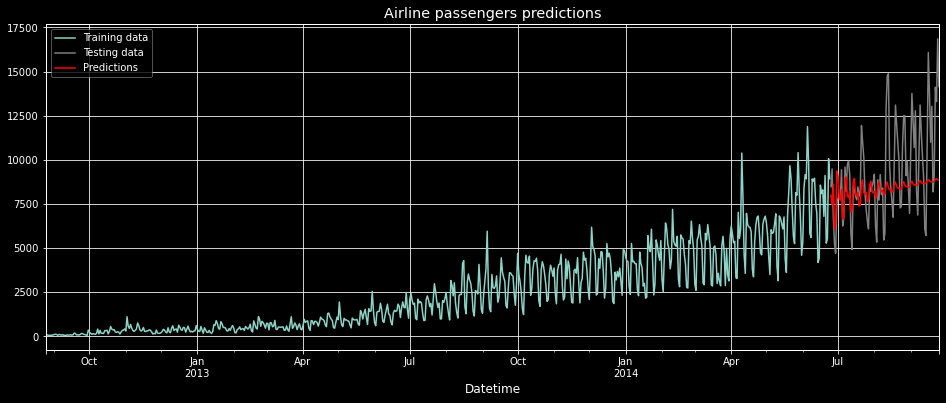

In [29]:
arima_model, arima_pred = arima_forecast(traind.Count, (8, 1, 1), 'D', validd)
# sets the lag value to 8 for autoregression. 
# sets the difference order of 1 to make the time series stationary. 
# sets the lag value to 1 for moving average.
plt.style.use('dark_background')
plot_forecast(traind, validd, arima_pred)

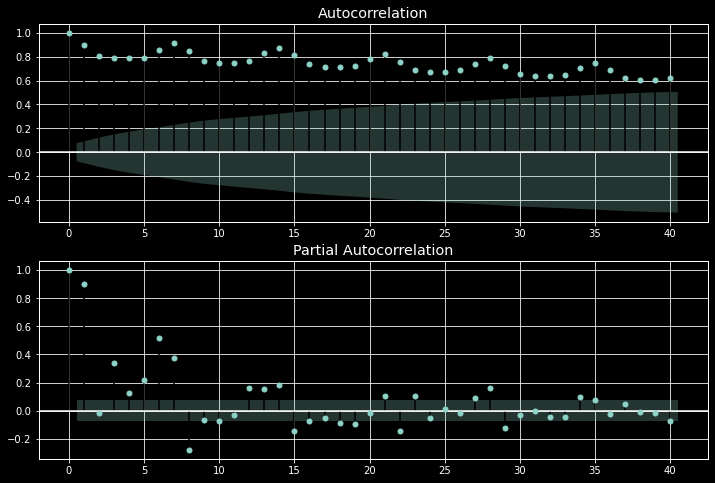

In [30]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(traind.Count, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(traind.Count, lags=40, ax=ax2)

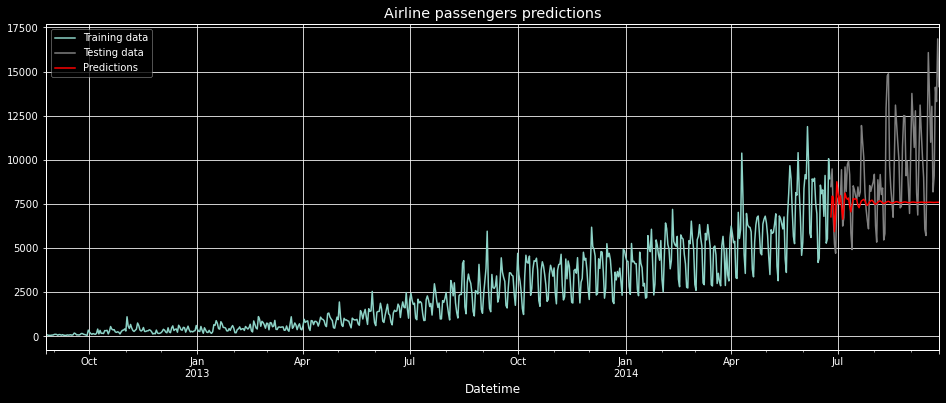

In [31]:
sarima_model = SARIMAX(traind.Count, order=(5,1,1))
res = sarima_model.fit().predict(start="2014-6-25", end="2014-9-25", dynamic=True) 

res_df = pd.DataFrame(index=validd.index, data=res.values, columns=["Count"])

plot_forecast(traind, validd, res_df)

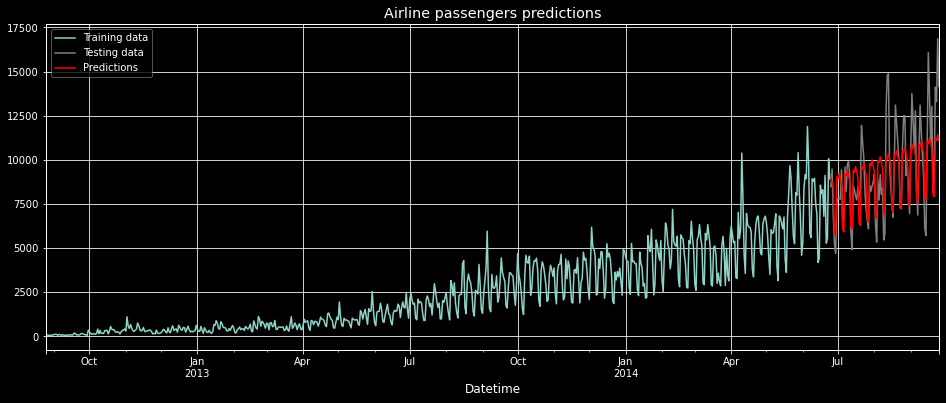

In [32]:
sarima_model2 = SARIMAX(traind.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit() 
res = sarima_model2.predict(start="2014-6-25", end="2014-9-25", dynamic=True) 

res_df = pd.DataFrame(index=res.index, data=res.values, columns=["Count"])

plot_forecast(traind, validd, res_df) 